In [16]:
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Fingerprints import FingerprintMols
import matplotlib.pyplot as plt

import pandas as pd

from descriptastorus.descriptors.DescriptorGenerator import MakeGenerator
#https://github.com/bp-kelley/descriptastorus


# Input both test/training dataset 

In [17]:
full_copy = pd.read_csv('../../../project1_data/Series4_full.csv', index_col = 'ID')

# full_copy['class'] = np.where(full_copy.desired >=5 , True, np.where(full_copy.desired < 5, False))

full_copy.loc[full_copy['desired'] >=6.0, 'class'] = 'active'
full_copy.loc[full_copy['desired'] <6.0, 'class'] = 'inactive'

# allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)

PandasTools.AddMoleculeColumnToFrame(full_copy,smilesCol='SMILES')
# full_copy.head()

# Generating descriptors using RDKit

In [18]:
# RDKit
generator = MakeGenerator(("RDKit2D",))

full_copy_rdkit2d = [generator.process(x)[1:] for x in full_copy['SMILES']]

In [19]:
rdkit2d_name = []
for name, numpy_type in generator.GetColumns():
    rdkit2d_name.append(name)
    
full_copy_rdkit2d_df = pd.DataFrame(full_copy_rdkit2d, index = full_copy.index, columns=rdkit2d_name[1:])

In [20]:
# full_copy_rdkit2d_df.head()

# MACCS keys 

In [21]:
# full_copy_MAACS = [MACCSkeys.GenMACCSKeys(x) for x in full_copy['ROMol']]
# full_copy_MAACS_list = [list(l) for l in full_copy_MAACS]
# maccs_name = [f'Bit_{i}' for i in range(167)]
# full_copy_MAACS_df = pd.DataFrame(full_copy_MAACS_list, index = full_copy.index, columns=maccs_name)
# full_copy_MAACS_df

In [22]:
# Mergind MACCS and RDKit descriptors

# full_copy_rdkit2d_df = pd.merge(full_copy_MAACS_df,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
# full_copy_rdkit2d_df.shape

In [59]:
full_copy_rdkit2d_df.to_csv('../../../project1_data/from_PP/full_copy_rdkit2d_df.csv')

In [60]:
TrainTest=full_copy.drop(full_copy[full_copy.type == 'validation'].index)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded'].index, inplace=True)
TrainTest.drop(TrainTest[TrainTest.type == 'excluded_subset'].index, inplace=True)

# full_copy.shape
validation=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
validation.drop(validation[validation.type == 'excluded'].index, inplace=True)
validation.drop(validation[validation.type == 'excluded_subset'].index, inplace=True)

excluded=full_copy.drop(full_copy[full_copy.type == 'TestTrain'].index)
excluded.drop(excluded[excluded.type == 'validation'].index, inplace=True)
excluded.drop(excluded[excluded.type == 'excluded'].index, inplace=True)


# TrainTest.head()

# Including PP data

In [81]:
full_copy_rdkit2d_df = pd.read_csv('../../../project1_data/from_PP/desirable-database_2020-09-10_ONLY-PPP-descriptors.csv', index_col = 'ID')
full_copy_rdkit2d_df.head()
allMerged = pd.merge(TrainTest,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_validation = pd.merge(validation,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged_excluded = pd.merge(excluded,full_copy_rdkit2d_df,left_on='ID',right_on='ID')
allMerged.shape

(196, 174)

In [65]:
allMerged.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
allMerged_validation.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
allMerged_excluded.drop(['type', 'Cluster member', 'Cluster type', 'ROMol', 'MCS Cluster', 'smiles_stardard'], axis=1, inplace=True)
# allMerged.dropna(inplace=True)

# allMerged.drop(['desired'], axis=1, inplace=True)
# allMerged_validation.drop(['desired'], axis=1, inplace=True)
# # allMerged_validation.drop(allMerged_validation[allMerged_validation.clearance < 7].index, inplace=True)
# allMerged_excluded.drop(['desired'], axis=1, inplace=True)
# allMerged_excluded.drop(allMerged_excluded[allMerged_excluded.clearance < 7].index, inplace=True)

allMerged.drop(['clearance','desired_type', 'desired'], axis=1, inplace=True)
allMerged_validation.drop(['clearance', 'desired_type', 'desired'], axis=1, inplace=True)
allMerged_excluded.drop(['clearance', 'desired_type', 'desired'], axis=1, inplace=True)

# allMerged.drop(allMerged[allMerged.clearance > 49.9].index, inplace=True)
# allMerged.drop(allMerged[allMerged.desired < 4.6].index, inplace=True)
# allMerged.drop(allMerged[allMerged.clearance < 0.51].index, inplace=True)
# allMerged[allMerged['clearance'] > 49.9 ]


In [78]:
# allMerged

# Random forest 

In [79]:
X = allMerged.iloc[:, 2:,].values #descreptors
# y = allMerged.iloc[:, 1].values #desired property

y = allMerged['class'].to_numpy()
# y

In [70]:
# print(X.shape)
# print(y)

r2_list = []
random_state_variable_list = []

for f in range(0,5,1):

    random_state_variable=f
    random_state_variable_list.append(f)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state_variable)
    print(X_train.shape)
    # print(X_test.shape)
    # print(y_train.shape)
    # print(y_test.shape)

    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    X_train.shape


    ### Starting Random Forest fitting

    from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

    regressor = RandomForestClassifier(n_estimators=500, random_state=random_state_variable)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    from sklearn import metrics

#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    r2_list.append(metrics.accuracy_score(y_test, y_pred))
#     print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#     from sklearn.metrics import r2_score
#     plt.scatter(y_test, y_pred)
#     m, b = np.polyfit(y_test, y_pred, 1)
#     plt.plot(y_test, m*y_test + b)
#     # plt.axes.set_title()
#     plt.title('R2: ' + str(r2_score(y_test, y_pred)))

print (random_state_variable_list)
print (r2_list)

(156, 163)
(156, 163)
(156, 163)
(156, 163)
(156, 163)
[0, 1, 2, 3, 4]
[0.8, 0.675, 0.725, 0.7, 0.825]


Text(0.5, 1.0, 'R2: 0.7567818176438006')

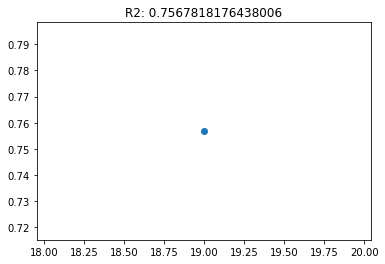

In [156]:
from sklearn.metrics import r2_score
plt.scatter(random_state_variable_list, r2_list)
plt.title('R2: ' + str(r2_score(y_test, y_pred)))


# Validation datasets

In [80]:
# X_valid = allMerged_validation.iloc[:, 2:,].values #descreptors
# y_valid = allMerged_validation.iloc[:, 1].values #desirable data

allMerged_excluded.dropna(inplace=True)
X_valid = allMerged_excluded.iloc[:, 2:,].values #descreptors
y_valid = allMerged_excluded.iloc[:, 1].values #desirable data

X_valid.shape
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_valid_norm = sc.fit_transform(X_valid)
X_valid_norm.shape
# allMerged_excluded.dropna(inplace=True)
# allMerged_excluded
# allMerged_excluded

(38, 163)

In [77]:
Y_valid_pred = regressor.predict(X_valid_norm)
print(Y_valid_pred)
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_valid, Y_valid_pred))
# print('Mean Squared Error:', metrics.mean_squared_error(y_valid, Y_valid_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_valid, Y_valid_pred)))
# print('XXXXXXXXXXXXXXXXXXXXX')
# plt.scatter(y_valid, Y_valid_pred)
# m, b = np.polyfit(y_valid, Y_valid_pred, 1)
# plt.plot(y_valid, m*y_valid + b)
# plt.title('R2: ' + str(r2_score(y_valid, Y_valid_pred)))

['inactive' 'inactive' 'active' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'active' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'active' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'inactive' 'inactive' 'inactive' 'inactive' 'inactive'
 'inactive' 'active' 'inactive' 'inactive' 'inactive' 'inactive' 'active'
 'inactive']


# Visualising leaves

In [ ]:
from sklearn.tree import export_graphviz
export_graphviz(estimator_limited, out_file='tree_limited.dot', feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, precision = 2, filled = True)


In [79]:
estimator_limited = regressor.estimators_[5]